# Correlation
- Work in GHz and ns

## First try to get the usual relaxation dynamics

<IPython.core.display.Javascript object>


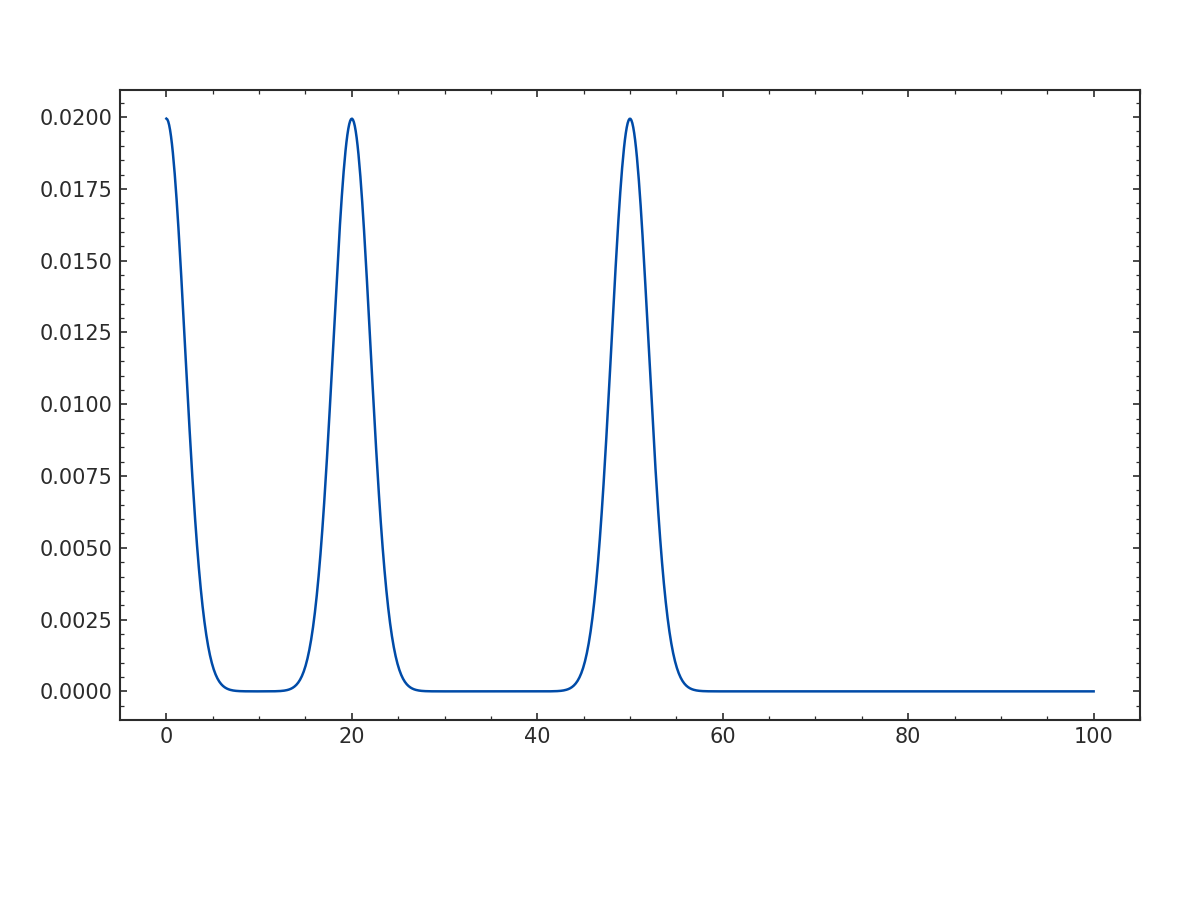

In [6]:
plt.style.use('./support_files/qubit-01.mplstyle')

def guassian_pulse(amplitude, sigma):
    """
    Returns a function that simulates Gaussian pulses at specified times
    """
    amplitude = amplitude / np.sqrt(2 * np.pi * sigma**2)
    exponent = - 1 / (2 * sigma**2)
    def kernel(t, args):
        return sum([amplitude * np.exp(exponent * (t-T)**2) for T in args['T']])
    return kernel

t = np.linspace(0, 100, 1000)
amplitude = 0.1
sigma = 2#ns

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(t, guassian_pulse(amplitude, sigma)(t, {
    'T': [0, 20, 50]
}));

<IPython.core.display.Javascript object>


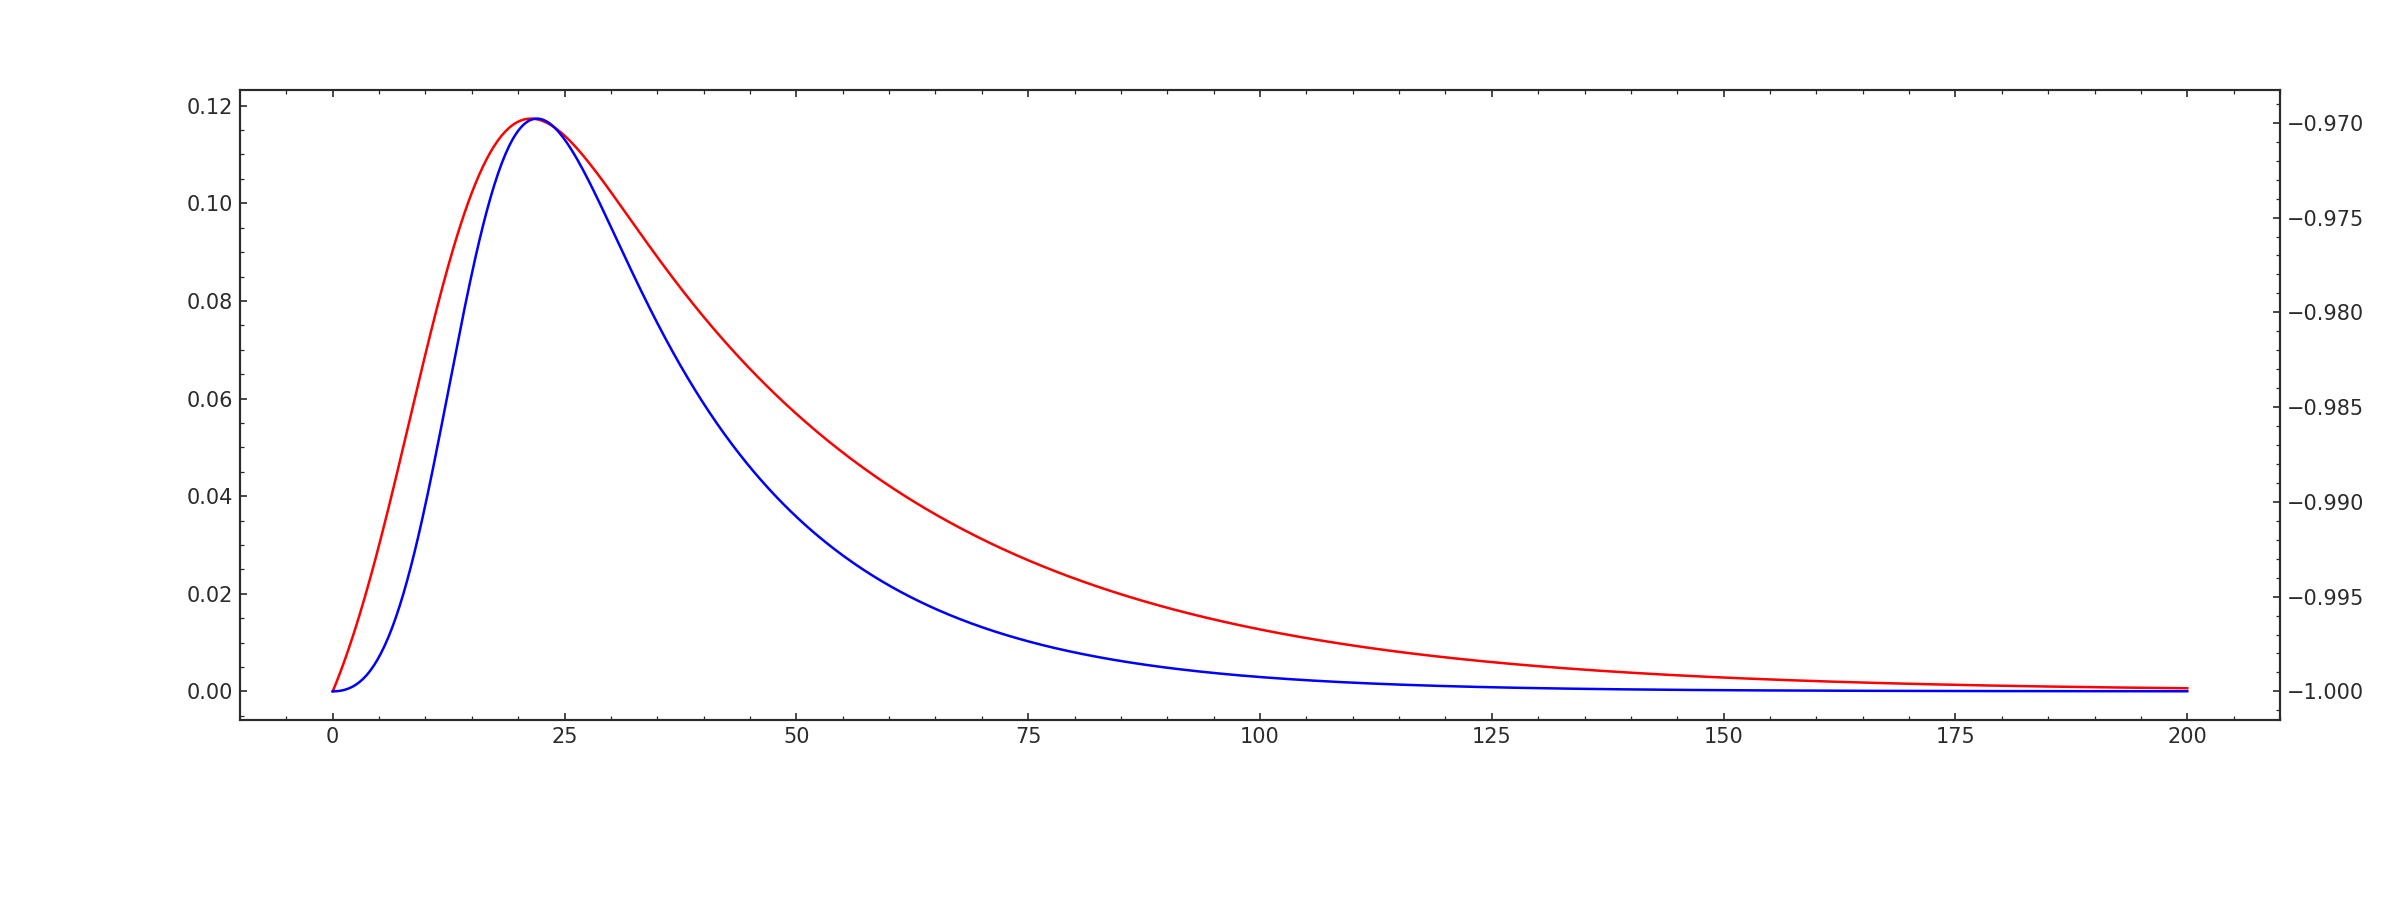

In [7]:
# Assume resonance, so that driving at the qubit frequency
initial_state = qutip.basis(2, 1)
amplitude = 0.2
sigma = 8 #ns
time_list = np.linspace(0.0, 200.0, 1000)
T_1 = 20 #ns
GAMMA_1 = 1/T_1
GAMMA_PHI = GAMMA_1/10
T = [10, 510, 1110]

H = [[qutip.sigmax(), guassian_pulse(amplitude, sigma)]]
JUMP_OPERATOR_GAMMA_1 = np.sqrt(GAMMA_1) * qutip.sigmam()
JUMP_OPERATOR_GAMMA_PHI = np.sqrt(GAMMA_PHI/2) * qutip.sigmaz()
collapse_operators = [JUMP_OPERATOR_GAMMA_1, JUMP_OPERATOR_GAMMA_PHI]

simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        collapse_operators, 
        [
            qutip.sigmam(), qutip.sigmaz()
        ],
        args={
#             'T': [30, 150]
            'T': T
        }
)

fig, ax = plt.subplots(1, 1, figsize=(16,6))
ax.plot(time_list, np.abs(simulation_result.expect[0]), color='red', label="dephasing")
ax = ax.twinx()
ax.plot(time_list, simulation_result.expect[1], color='blue', label="relaxation")

## g2 Manually
Passing in both time lists, will return a matrix, as a function of the two coordinates ($t_1$ and $t2$).

So for example 
\begin{equation}
  g^{(2)}(t_1, t_1+t_2) = g^{(2)}(0, 0+10)
\end{equation}

will be the value at $t_1=0, t_2=10$

As we want $g^{(2)}(\tau)$, we need to integrate out the first coordinate, by averaging out all points with the same time delay

\begin{equation}
  g^{(2)}(t_2) = \frac{1}{N} \sum_{t_i}g^{(2)}(t_i, t_i+t_2)
\end{equation}

In [8]:
time_list = np.linspace(0, 1000.0, 2000)
# T = [25, 75, 125, 175, 225, 275, 325, 375, 425, 475, 525, 575, 625, 675, 725, 775, 825, 875]
T = [10, 310, 610, 910, 1210, 1510, 1810]

H = [[qutip.sigmax(), guassian_pulse(amplitude, sigma)]]

result = qutip.correlation_3op_2t(
    H,
    initial_state * initial_state.dag(),
    time_list,
    time_list,
    collapse_operators,
    qutip.sigmap(),
    qutip.sigmap() * qutip.sigmam(),
    qutip.sigmam(),
    args={'T': T}
)

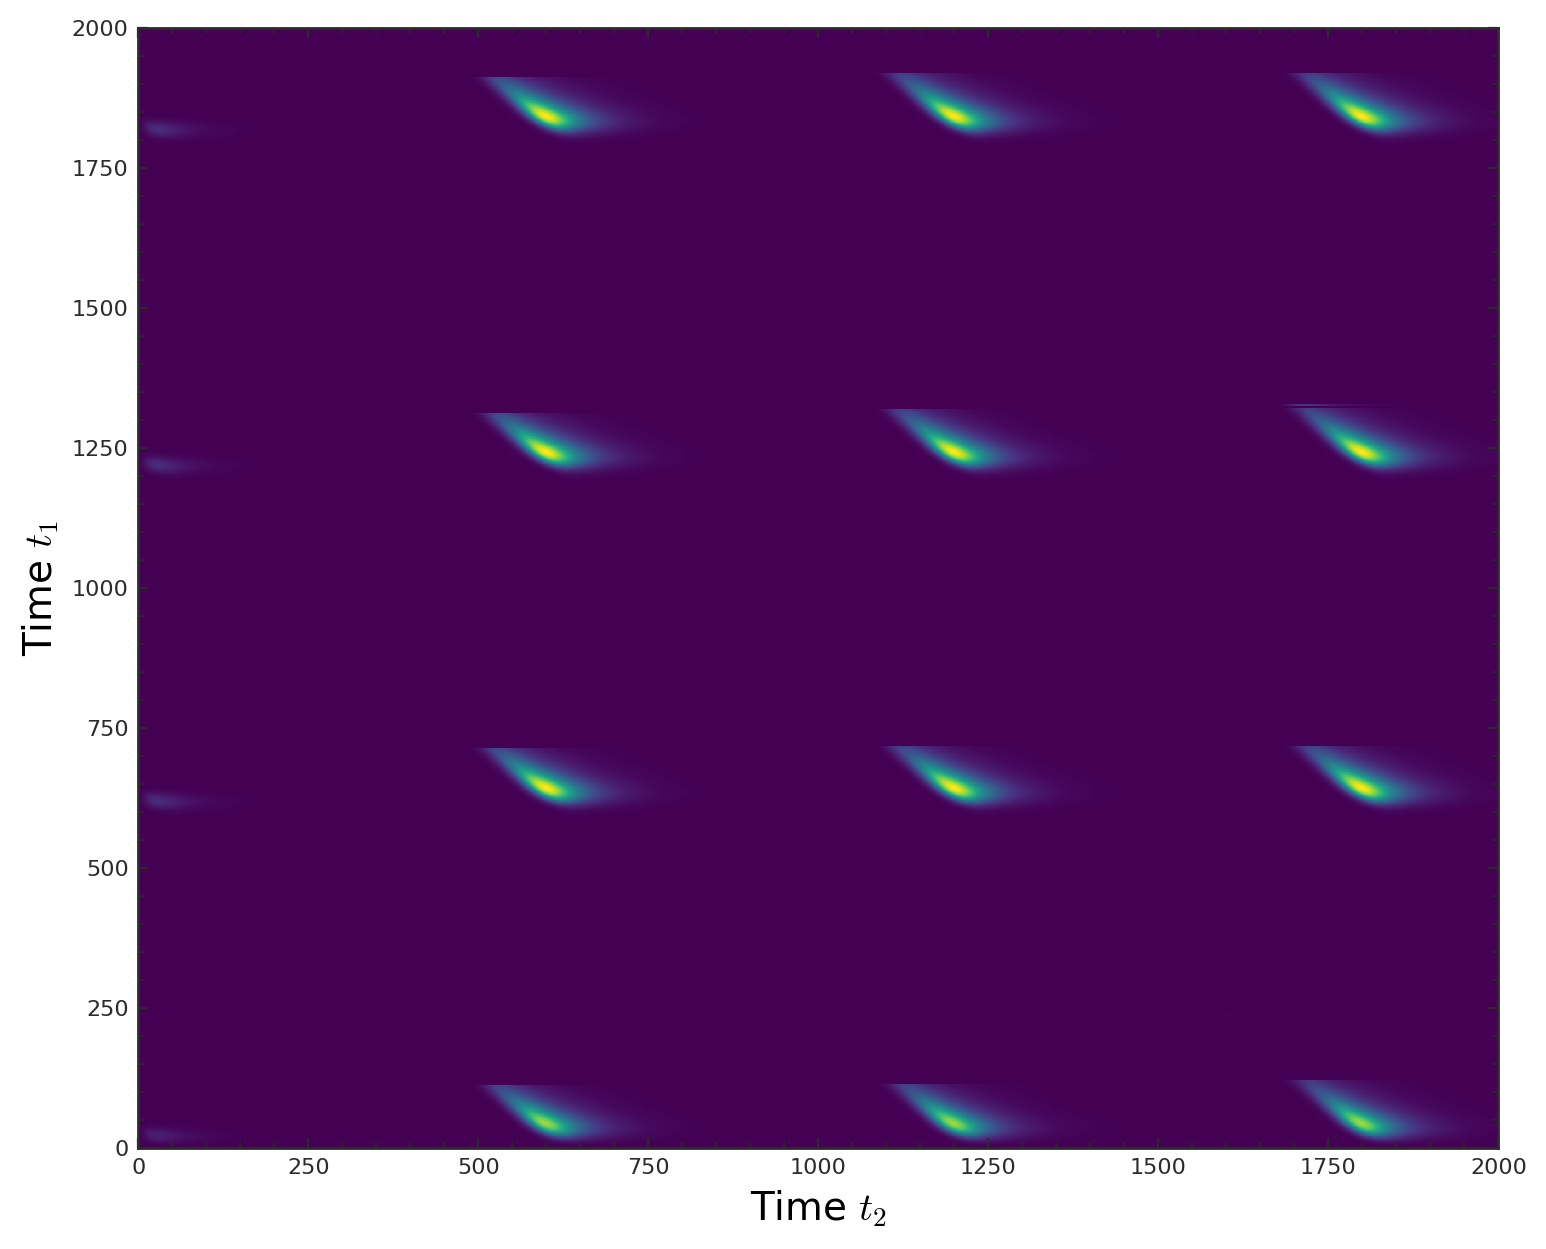

In [381]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.pcolor(np.real(result))
ax.set_xlabel(r"Time $t_2$")
ax.set_ylabel(r"Time $t_1$");

<IPython.core.display.Javascript object>


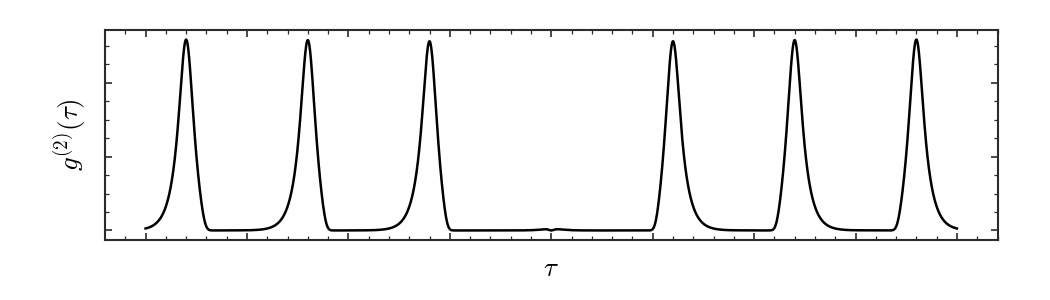

In [25]:
# Thus we need to take and sum up the slices for each t2 time

g2 = []
for idx, t2_result in enumerate(result.transpose()):
    val = np.abs(sum(t2_result))
    if idx > 300:
        g2.append(val)
    else:
        g2.append(val/10)
    
symmetric_g2 = [*np.flip(g2), *g2]
symmetric_t = [*np.flip(-time_list), *time_list]

fig, ax = plt.subplots(1, 1, figsize=(7,2))
ax.plot(symmetric_t, symmetric_g2, color='black');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_ylabel(r"$g^{(2)}(\tau)$")
ax.set_xlabel(r"$\tau$")
plt.savefig('./output/g2-source.svg')

<IPython.core.display.Javascript object>


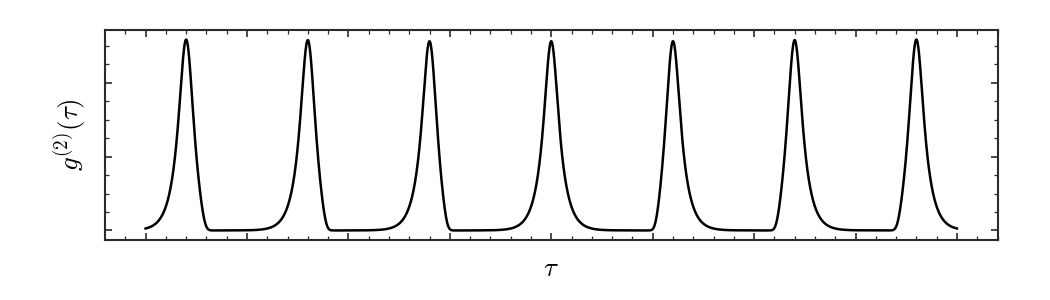

In [26]:
# Sub summetrised values for the central peak to mimic coherent source (as otherwise I need to mimic a coherent source and I do not know how to do that)
coherent_result = result.transpose()
g2 = []
replacement_index = 600
for idx, t2_result in enumerate(coherent_result):
    if (idx < 350):
        t2_result = coherent_result[replacement_index+(idx)]
    
    val = np.abs(sum(t2_result))
    g2.append(val)
    
symmetric_g2 = [*np.flip(g2), *g2]
symmetric_t = [*np.flip(-time_list), *time_list]

fig, ax = plt.subplots(1, 1, figsize=(7,2))
ax.plot(symmetric_t, symmetric_g2, color='black');
# ax.axvline(replacement_index * 0.5)
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_ylabel(r"$g^{(2)}(\tau)$")
ax.set_xlabel(r"$\tau$")

plt.savefig('./output/g2-coherent.svg')

## g1 correlation function (not scaled)

In [ ]:
tau_list = np.linspace(0.0, 400.0, 400)

amplitude = 1
H = [[qutip.sigmax(), guassian_pulse(amplitude, sigma)]]

result = qutip.correlation_2op_2t(
    H,
    initial_state * initial_state.dag(),
    tau_list,
    tau_list,
    collapse_operators,
    qutip.sigmap(),
    qutip.sigmam(),
    args={'T': T}
)

Text(0, 0.5, 'Time $t_1$')

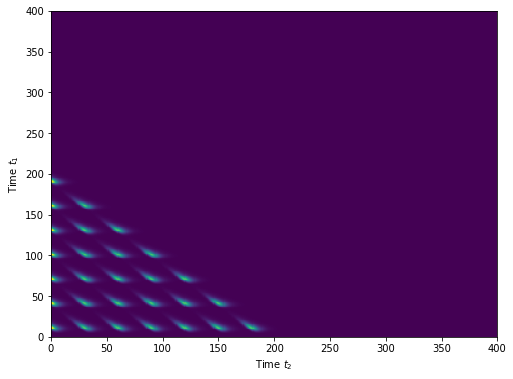

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.pcolor(np.real(result))
ax.set_xlabel(r"Time $t_2$")
ax.set_ylabel(r"Time $t_1$")

Text(0, 0.5, 'Time $t_1$')

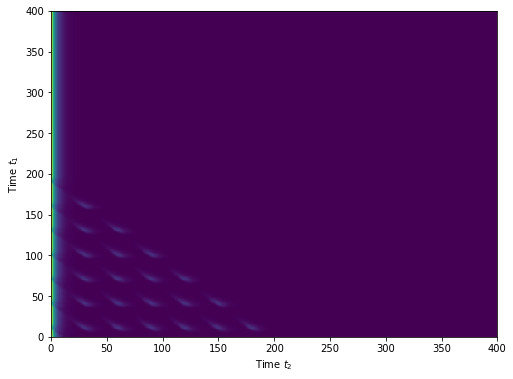

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.pcolor(np.imag(result))
ax.set_xlabel(r"Time $t_2$")
ax.set_ylabel(r"Time $t_1$")

# Solving 3 level atom

In [2]:
one, two, three = qutip.qutrit_basis()
def build3LevelHam(dw01, dw12, Omega01, Omega12):
    sig00 = 2*dw01*one * one.dag()
    sig22 = 2 * dw12* three * three.dag()
    sig01 = - Omega01 * one * two.dag()
    sig10 = - Omega01 * two * one.dag()
    sig21 = - Omega12 * two * three.dag()
    sig12 = - Omega12 * three * two.dag()
    
    return  sig00 + sig22 + sig01 + sig10 + sig21 + sig12

def buildLinbland(Gamma01, Gamma02, Gamma12):
    
    gamma01 = Gamma01 / 2
    gamma02 = Gamma02 / 2
    gamma12 = Gamma12 / 2
    
    return [ 
        np.sqrt(Gamma01) * one * two.dag(),
        np.sqrt(Gamma02) * one * three.dag(),
        np.sqrt(Gamma12) * two * three.dag(),   
    ]

sig01 = one * two.dag()

## How long dynamics take to reach stationary state

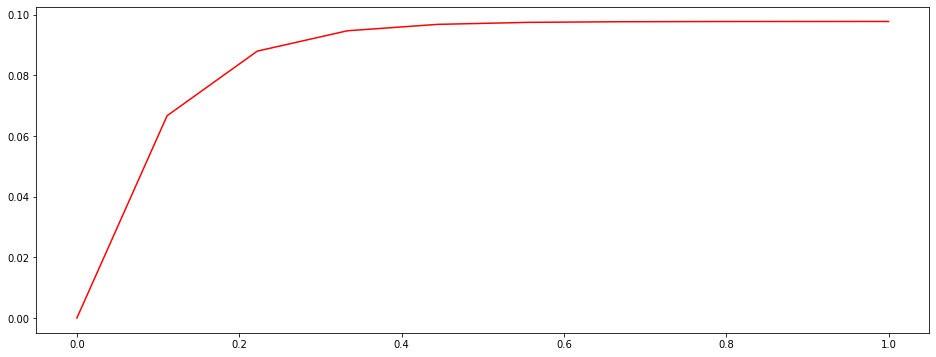

In [86]:
Gamma01 = 20
Gamma12 = 40
Gamma02 = 40

H = build3LevelHam(0, 0, 1, 1)
L = buildLinbland(Gamma01, Gamma12, Gamma02)
initial_state = qutip.qutrit_basis()[0]
time_list = np.linspace(0.0, 1.0, 10)

simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        L, 
        [
            sig01,
        ]
)

fig, ax = plt.subplots(1, 1, figsize=(16,6))
ax.plot(time_list, np.abs(simulation_result.expect[0]), color='red', label="dephasing")

## Driving just the first tone
- We see the regular splitting when stregnth of 1st tone is increased

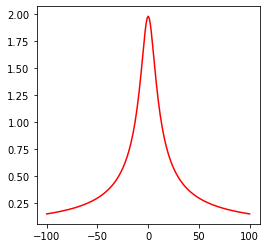

In [146]:
Gamma01 = 30
Gamma12 = 10
Gamma02 = 10

# Example very weak drive
Omega01 = 1
Omega12 = 0

POINTS = 201
dw12 = 0
dw01_arr = np.linspace(-100,100, POINTS)

L = buildLinbland(Gamma01, Gamma12, Gamma02)
initial_state = qutip.qutrit_basis()[0]
time_list = np.linspace(0.0, 1.0, 40)

emission = np.zeros(POINTS, dtype=np.complex_)
for j, dw01 in enumerate(dw01_arr):
    H = build3LevelHam(dw01, dw12, Omega01, Omega12)
    simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        L, 
        [
            sig01,
        ]
    )
    emission[j] = simulation_result.expect[0][-1]
    
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(dw12_arr, Gamma01 / Omega01 * np.abs(emission), color='red')

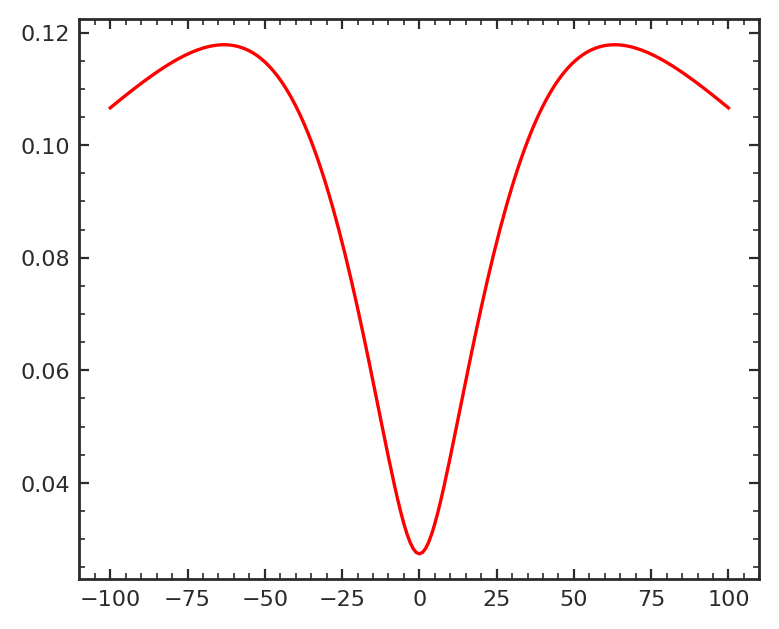

In [122]:
Gamma01 = 30
Gamma12 = 10
Gamma02 = 10

# Strong
Omega01 = 90
Omega12 = 0

POINTS = 201
dw12 = 0
dw01_arr = np.linspace(-100,100, POINTS)

L = buildLinbland(Gamma01, Gamma12, Gamma02)
initial_state = qutip.qutrit_basis()[0]
time_list = np.linspace(0.0, 1.0, 40)

emission = np.zeros(POINTS, dtype=np.complex_)
for j, dw01 in enumerate(dw01_arr):
    H = build3LevelHam(dw01, dw12, Omega01, Omega12)
    simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        L, 
        [
            sig01,
        ]
    )
    emission[j] = simulation_result.expect[0][-1]
    
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(dw01_arr, Gamma01 / Omega01 * np.abs(emission), color='red')

## First tone on resonance - sweeping 2nd tone

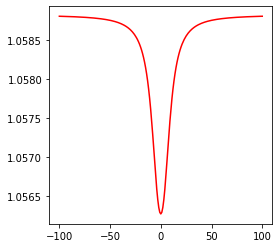

In [149]:
Gamma01 = 30
Gamma12 = 10
Gamma02 = 10

Omega01 = 10 # Use the weak drive
Omega12 = 1

POINTS = 201
dw01 = 0
dw12_arr = np.linspace(-100,100, POINTS)

L = buildLinbland(Gamma01, Gamma12, Gamma02)
initial_state = qutip.qutrit_basis()[0]
time_list = np.linspace(0.0, 1.0, 40)

emission = np.zeros(POINTS, dtype=np.complex_)
for j, dw12 in enumerate(dw12_arr):
    H = build3LevelHam(dw01, dw12, Omega01, Omega12)
    simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        L, 
        [
            sig01,
        ]
    )
    emission[j] = simulation_result.expect[0][-1]
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(dw12_arr, Gamma01 / Omega01 * np.abs(emission), color='red', label="dephasing")

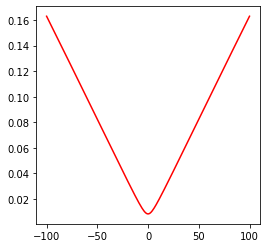

In [160]:
Gamma01 = 30
Gamma12 = 10
Gamma02 = 10

Omega01 = 10 # Use the weak drive
Omega12 = 190

POINTS = 201
dw01 = 0
dw12_arr = np.linspace(-100,100, POINTS)

L = buildLinbland(Gamma01, Gamma12, Gamma02)
initial_state = qutip.qutrit_basis()[0]
time_list = np.linspace(0.0, 1.0, 40)

emission = np.zeros(POINTS, dtype=np.complex_)
for j, dw12 in enumerate(dw12_arr):
    H = build3LevelHam(dw01, dw12, Omega01, Omega12)
    simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        L, 
        [
            sig01,
        ]
    )
    emission[j] = simulation_result.expect[0][-1]
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(dw12_arr, Gamma01 / Omega01 * np.abs(emission), color='red', label="dephasing")

## Strong

In [3]:
Gamma01 = 10
Gamma12 = 20
Gamma02 = 20

Omega01 = 10
Omega12 = 25

POINTS = 51
dw01_arr = np.linspace(-200, 200, POINTS)
dw12_arr = np.linspace(-200, 200, POINTS)
L = buildLinbland(Gamma01, Gamma12, Gamma02)
initial_state = qutip.qutrit_basis()[0]
time_list = np.linspace(0.0, 1.0, 20)

emission = np.zeros((POINTS, POINTS), dtype=np.complex_)
for i, dw01 in enumerate(dw01_arr):
    for j, dw12 in enumerate(dw12_arr):
        H = build3LevelHam(dw01, dw12, Omega01, Omega12)
        simulation_result = qutip.mesolve(
            H, initial_state, time_list, 
            L, 
            [
                sig01,
            ]
        )
        emission[i,j]=simulation_result.expect[0][-1]

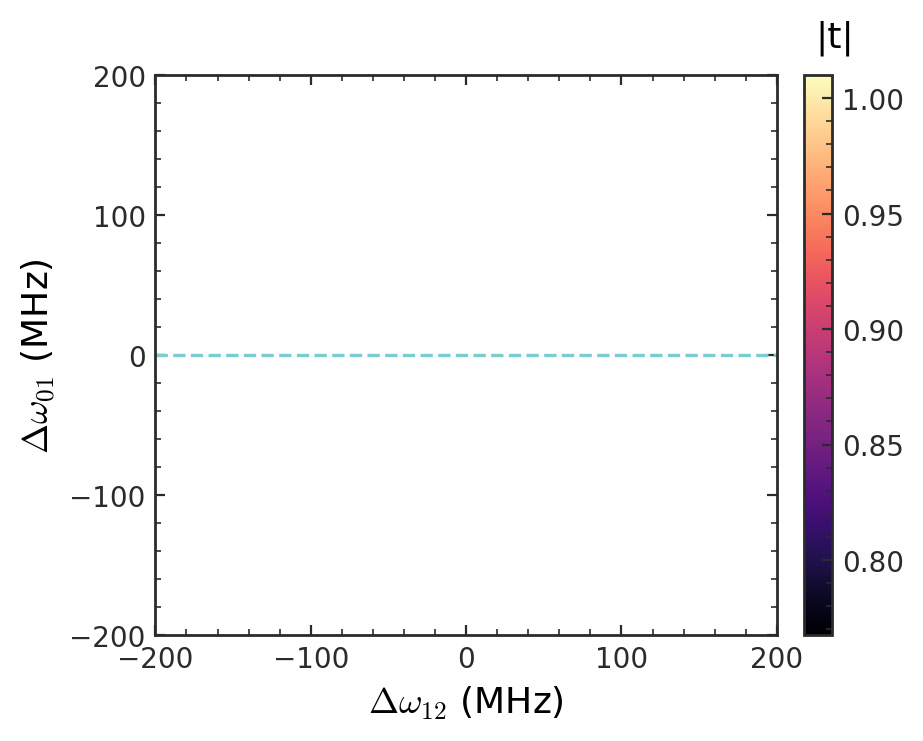

In [5]:
BASENAME = "./output/two-tone_strong-drive"
x, y = np.meshgrid(dw01_arr, dw12_arr)
transmission = np.abs(1 + 1j * Gamma01 / Omega01 * emission)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
im = ax.pcolormesh(x, y,
               transmission, 
               shading='gouraud',
               cmap=cm.magma,
                   vmax = 1.01
              )
fit = ax.axhline(0, linestyle="--", color="C1")
ax.set_xlabel("$\Delta\omega_{12}$ (MHz)")
ax.set_ylabel("$\Delta\omega_{01}$ (MHz)")
ax.set_xticks([-200, -100, 0, 100, 200])
ax.set_yticks([-200, -100, 0, 100, 200])
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.ax.set_ylabel(r"|t|",
                 rotation=0, ha="left", 
                 labelpad=-32, 
                 y=1.1
                )

# PNG
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# cb.remove() 
# fit.remove()
# ax.axis('off') 
# plt.savefig(f"{BASENAME}.png", dpi=300, transparent=True, bbox_inches='tight',  pad_inches=0)

# SVG
im.remove()
plt.savefig(f"{BASENAME}.svg", transparent=True)

In [183]:
POINTS = 201
dw01 = 0
dw12_arr_lin = np.linspace(-200,200, POINTS)

emission_lin = np.zeros(POINTS, dtype=np.complex_)
for j, dw12 in enumerate(dw12_arr_lin):
    H = build3LevelHam(dw01, dw12, Omega01, Omega12)
    simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        L, 
        [
            sig01,
        ]
    )
    emission_lin[j] = simulation_result.expect[0][-1]

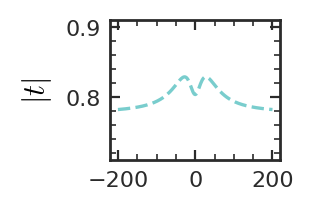

In [184]:
transmission = np.abs(1 + 1j * Gamma01 / Omega01 * emission_lin)
MIDPOINT = 0.81
SPAN = 0.1

fig, ax = plt.subplots(1, 1, figsize=(1,1))
ax.plot(
    dw12_arr_lin, 
    transmission,
    color='C1', 
    linestyle="--")
ax.set_ylabel("$|t|$")
ax.set_ylim([MIDPOINT - SPAN, MIDPOINT + SPAN])

plt.savefig(f"{BASENAME}_cross-section.svg", transparent=True)

## Weak

In [6]:
Gamma01 = 10
Gamma12 = 20
Gamma02 = 20

Omega01 = 10
Omega12 = 5

POINTS = 51
dw01_arr = np.linspace(-200, 200, POINTS)
dw12_arr = np.linspace(-200, 200, POINTS)
L = buildLinbland(Gamma01, Gamma12, Gamma02)
initial_state = qutip.qutrit_basis()[0]
time_list = np.linspace(0.0, 1.0, 20)

emission = np.zeros((POINTS, POINTS), dtype=np.complex_)
for i, dw01 in enumerate(dw01_arr):
    for j, dw12 in enumerate(dw12_arr):
        H = build3LevelHam(dw01, dw12, Omega01, Omega12)
        simulation_result = qutip.mesolve(
            H, initial_state, time_list, 
            L, 
            [
                sig01,
            ]
        )
        emission[i,j]=simulation_result.expect[0][-1]

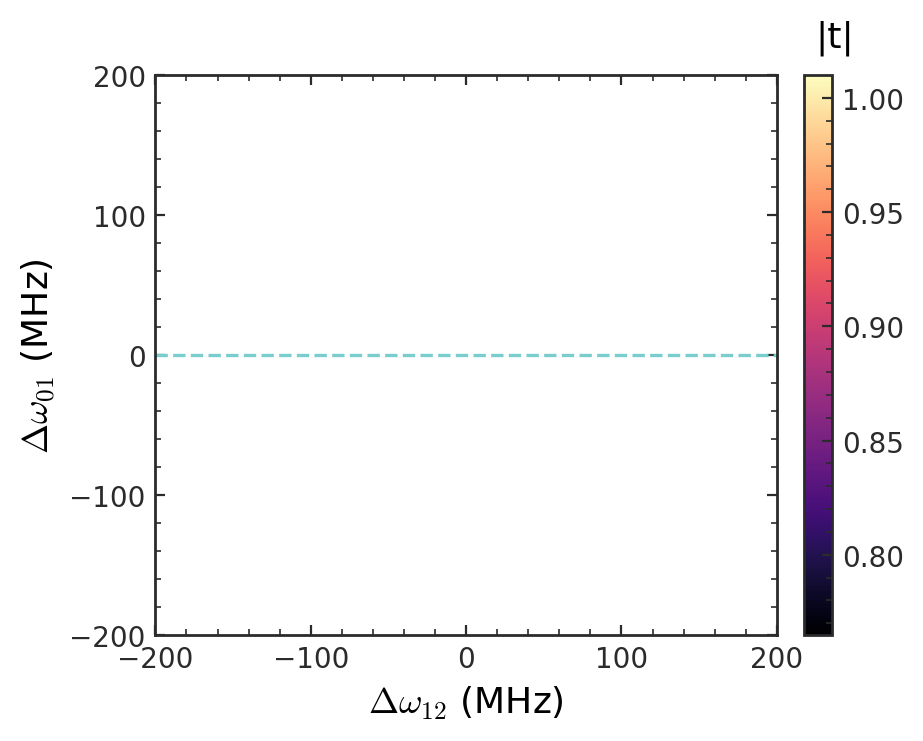

In [7]:
BASENAME = "./output/two-tone_weak_drive"

x, y = np.meshgrid(dw01_arr, dw12_arr)
transmission = np.abs(1 + 1j * Gamma01 / Omega01 * emission)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
im = ax.pcolormesh(x, y,
               transmission, 
               shading='gouraud',
               cmap=cm.magma,
                   vmax = 1.01
              )
fit = ax.axhline(0, linestyle="--", color="C1")
ax.set_xlabel("$\Delta\omega_{12}$ (MHz)")
ax.set_ylabel("$\Delta\omega_{01}$ (MHz)")
ax.set_xticks([-200, -100, 0, 100, 200])
ax.set_yticks([-200, -100, 0, 100, 200])
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.ax.set_ylabel(r"|t|",
                 rotation=0, ha="left", 
                 labelpad=-32, 
                 y=1.1
                )

# PNG
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# cb.remove() 
# fit.remove()
# ax.axis('off') 
# plt.savefig(f"{BASENAME}.png", dpi=300, transparent=True, bbox_inches='tight',  pad_inches=0)

# SVG
im.remove()
plt.savefig(f"{BASENAME}.svg", transparent=True)

In [170]:
POINTS = 201
dw01 = 0
dw12_arr_lin = np.linspace(-200,200, POINTS)

emission_lin = np.zeros(POINTS, dtype=np.complex_)
for j, dw12 in enumerate(dw12_arr_lin):
    H = build3LevelHam(dw01, dw12, Omega01, Omega12)
    simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        L, 
        [
            sig01,
        ]
    )
    emission_lin[j] = simulation_result.expect[0][-1]

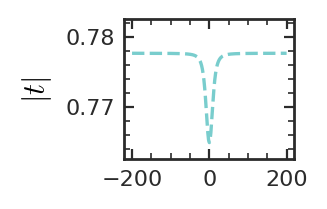

In [172]:
transmission = np.abs(1 + 1j * Gamma01 / Omega01 * emission_lin)

MIDPOINT = 0.7725
SPAN = 0.01

fig, ax = plt.subplots(1, 1, figsize=(1,1))
ax.plot(
    dw12_arr_lin, transmission, color='C1', 
    linestyle="--")
ax.set_ylabel("$|t|$")
ax.set_ylim([MIDPOINT - SPAN, MIDPOINT + SPAN])
plt.savefig(f"{BASENAME}_cross-section.svg", transparent=True)

## Strong control

In [8]:
Gamma01 = 10
Gamma12 = 20
Gamma02 = 20

Omega01 = 90
Omega12 = 10

POINTS = 51
dw01_arr = np.linspace(-200, 200, POINTS)
dw12_arr = np.linspace(-200, 200, POINTS)
L = buildLinbland(Gamma01, Gamma12, Gamma02)
initial_state = qutip.qutrit_basis()[0]
time_list = np.linspace(0.0, 1.0, 20)

emission = np.zeros((POINTS, POINTS), dtype=np.complex_)
for i, dw01 in enumerate(dw01_arr):
    for j, dw12 in enumerate(dw12_arr):
        H = build3LevelHam(dw01, dw12, Omega01, Omega12)
        simulation_result = qutip.mesolve(
            H, initial_state, time_list, 
            L, 
            [
                sig01,
            ]
        )
        emission[i,j]=simulation_result.expect[0][-1]

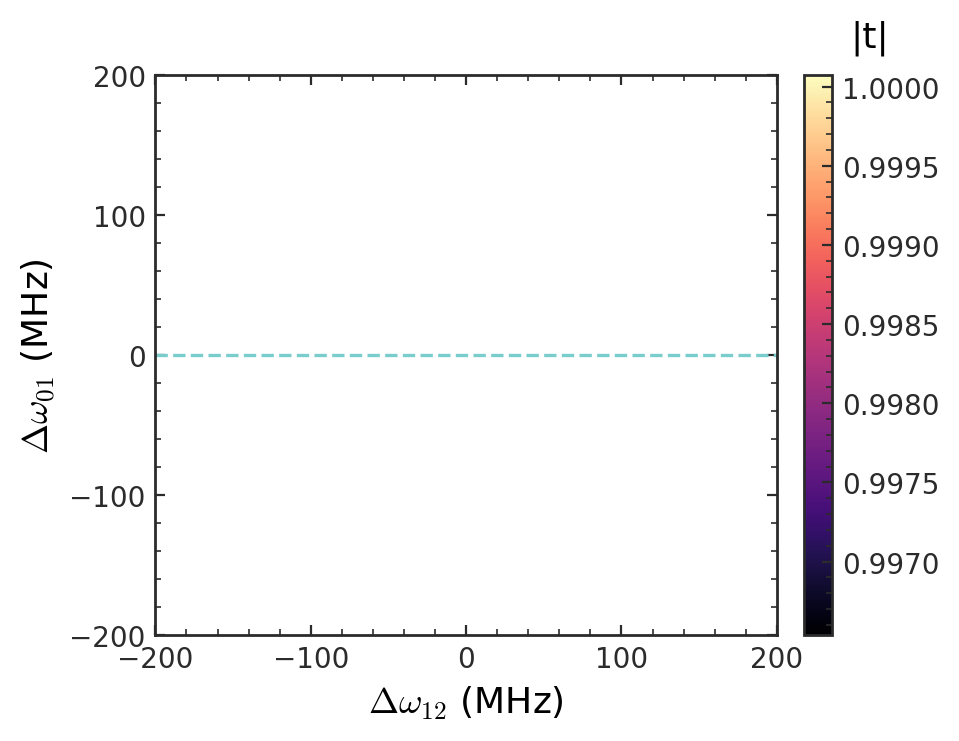

In [9]:
BASENAME = "./output/two-tone_strong_control"
x, y = np.meshgrid(dw01_arr, dw12_arr)
transmission = np.abs(1 + 1j * Gamma01 / Omega01 * emission)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
im = ax.pcolormesh(x, y,
                   transmission, 
                   shading='gouraud',
                   cmap=cm.magma,
#                    vmax = 1.01,
#                    vmin = 0.8
              )
fit = ax.axhline(0, linestyle="--", color="C1")
ax.set_xlabel("$\Delta\omega_{12}$ (MHz)")
ax.set_ylabel("$\Delta\omega_{01}$ (MHz)")
ax.set_xticks([-200, -100, 0, 100, 200])
ax.set_yticks([-200, -100, 0, 100, 200])
cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.ax.set_ylabel(r"|t|",
                 rotation=0, ha="left", 
                 labelpad=-32, 
                 y=1.1
                )

# PNG
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
# cb.remove() 
# fit.remove()
# ax.axis('off') 
# plt.savefig(f"{BASENAME}.png", dpi=300, transparent=True, bbox_inches='tight',  pad_inches=0)

# SVG
im.remove()
plt.savefig(f"{BASENAME}.svg", transparent=True)

In [177]:
POINTS = 201
dw01 = 0
dw12_arr_lin = np.linspace(-200,200, POINTS)

emission_lin = np.zeros(POINTS, dtype=np.complex_)
for j, dw12 in enumerate(dw12_arr_lin):
    H = build3LevelHam(dw01, dw12, Omega01, Omega12)
    simulation_result = qutip.mesolve(
        H, initial_state, time_list, 
        L, 
        [
            sig01,
        ]
    )
    emission_lin[j] = simulation_result.expect[0][-1]

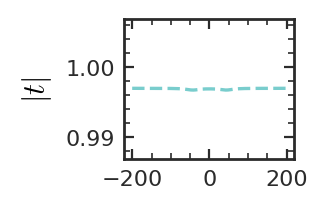

In [178]:
transmission = np.abs(1 + 1j * Gamma01 / Omega01 * emission_lin)

MIDPOINT = 0.99680
SPAN = 0.01

fig, ax = plt.subplots(1, 1, figsize=(1,1))
ax.plot(
    dw12_arr_lin, transmission, color='C1', 
    linestyle="--")
ax.set_ylabel("$|t|$")
ax.set_ylim([MIDPOINT - SPAN, MIDPOINT + SPAN])

plt.savefig(f"{BASENAME}_cross-section.svg", transparent=True)

# Alternative hamiltonian

In [ ]:
one, two, three = qutip.qutrit_basis()
def build3LevelHam(dw01, dw12, Omega01, Omega12):
    sig00 = 2*dw01*one * one.dag()
    sig22 = 2 * dw12* three * three.dag()
    sig01 = - Omega01 * one * two.dag()
    sig10 = - Omega01 * two * one.dag()
    sig21 = - Omega12 * two * three.dag()
    sig12 = - Omega12 * three * two.dag()
    
    return  sig00 + sig22 + sig01 + sig10 + sig21 + sig12

def buildLinbland(Gamma01, Gamma02, Gamma12):
    
    gamma01 = Gamma01 / 2
    gamma02 = Gamma02 / 2
    gamma12 = Gamma12 / 2
    
    return [ 
        np.sqrt(Gamma01) * one * two.dag(),
        np.sqrt(Gamma02) * one * three.dag(),
        np.sqrt(Gamma12) * two * three.dag(),   
    ]

sig01 = one * two.dag()